<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/TP10_analyses_donnees_textuelles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 10 : Analyses de données textuelles

Dans ce TP, nous allons effectuer quelques méthodes d'analyse textuelle sur les Misérables de Victor Hugo. Le texte des 5 tomes a été obtenu via le projet gutenberg (https://www.gutenberg.org/) et nous allons utiliser le texte en anglais.

Plusieurs librairies offrent des outils de traitement de données textuelles en Python, tel que **nltk**, **sklearn**, **spacy**, **gensim**, et **flair**. Ici, nous allons utiliser :

* Spacy (https://spacy.io/) : qui fournit plusieurs *modèles de langage* permettant d'effectuer des tâches de tokenisation, tagging et parsing. De nombreuses autres méthodes sont également disponibles.

* Gensim (https://radimrehurek.com/gensim/) : qui se concentre sur les méthodes de topic modeling et d'embedding, et qui permet de charger certains modèles pré-entrainés.

Notez que Python possède de nombreuses fonctionnalités permettant de traiter les chaînes de caractères (voir p.ex. https://www.w3schools.com/python/python_ref_string.asp
) et la librairie `re` permet de gerer les expression régulières (https://docs.python.org/3/library/re.html). Avec ces deux éléments, il est déjà possible de créer de nombreux traitements en partant de zéro.

Les librairies nécessaires sont les suivantes :

In [19]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
# Permet de créer des décomptes d'objet dans une liste
import collections
import matplotlib.pyplot as plt
# Permet de faire des grilles de graphique
from matplotlib.gridspec import GridSpec
# Pour les colormaps
from matplotlib import colormaps
# Pour traiter les expressions régulières
import re
# Pour les pré-traitements, le tagging et le parsing
import spacy
# Aide pour la décompositon spectrale nécessaire à l'AFC
import scipy
# Pour la LDA et les word embeddings : gensim.
# Installation sur colab
!pip install gensim
# Importation
import gensim
from gensim.models import TfidfModel, LdaModel, CoherenceModel, Word2Vec
# Pour projeter les coordonnées
from sklearn.manifold import TSNE

---

## 1. Pré-traitements et statistiques

### 1.1 Séparation du texte en plusieurs documents

Le corpus des Misérables en anglais est contenu dans un seul fichier. Seulement, nous allons adopter une structure de données où chaque document de notre corpus est contenu dans un fichier séparé. Pour cela, nous allons séparer notre texte à l'aide d'expressions régulières.

On commence par charger le corpus par lignes.

In [20]:
corpus_path = "/content/drive/MyDrive/Colab Notebooks/" \
              "ml_data/TP10/les_miserables.txt"
with open(corpus_path) as corpus_file:
  corpus_lines = corpus_file.readlines()

In [21]:
corpus_lines[0:11]

['LES MISÉRABLES\n',
 '\n',
 '\n',
 '\n',
 '\n',
 'PREFACE\n',
 '\n',
 '\n',
 'So long as there shall exist, by virtue of law and custom, decrees of\n',
 'damnation pronounced by society, artificially creating hells amid the\n',
 'civilization of earth, and adding the element of human fate to divine\n']

Nous allons maintenant définir des expressions régulières qui permettent d'identifier les lignes séparatrices de notre corpus. Il y a trois échelons possibles: Volume (e.g. "VOLUME I"), livre (e.g. "BOOK FIRST-A JUST MAN") et chapitre (e.g. "CHAPTER I—M. MYRIEL").

In [22]:
regex_for_volume = "^VOLUME [A-Z]+$"
regex_for_book = "^BOOK "
regex_for_chapter = "^CHAPTER "

La boucle suivante ajoute les lignes une par une dans une variable, puis sauve cette variable (et la vide) une fois qu'une ligne séparatrice de l'unité choisie apparaît (attention, on sauve également la dernière itération de la variable). Ici, nous allons séparer notre corpus par livre avec `regex_for_book` (on omet toute les lignes qui contiennent des séparateurs).

In [23]:
book_texts = []
text = ""
# Boucle sur les lignes
for line in corpus_lines:
  # Si c'est une ligne avec "BOOK ...", ou la fin, on sauve le texte
  if re.match(regex_for_book, line) or line == corpus_lines[-1]:
    book_texts.append(text)
    text = ""
  # Ajout de la une ligne si ce n'est pas "VOLUME", "BOOK", "CHAPTER"
  if re.match(regex_for_volume, line) is None and \
     re.match(regex_for_book, line) is None and \
     re.match(regex_for_chapter, line) is None:
    text += line

# Affichage du début des deux premiers chapitres
print(book_texts[0][0:600])
print("----------------------------")
print(book_texts[1][0:600])

LES MISÉRABLES




PREFACE


So long as there shall exist, by virtue of law and custom, decrees of
damnation pronounced by society, artificially creating hells amid the
civilization of earth, and adding the element of human fate to divine
destiny; so long as the three great problems of the century—the
degradation of man through pauperism, the corruption of woman through
hunger, the crippling of children through lack of light—are unsolved;
so long as social asphyxia is possible in any part of the world;—in
other words, and with a still wider significance, so long as ignorance
and poverty exist 
----------------------------





In 1815, M. Charles-François-Bienvenu Myriel was Bishop of D—— He was
an old man of about seventy-five years of age; he had occupied the see
of D—— since 1806.

Although this detail has no connection whatever with the real substance
of what we are about to relate, it will not be superfluous, if merely
for the sake of exactness in all points, to mention here the v

Finalement, on sauve les différents documents dans un nouveau dossier, afin de n'avoir plus à refaire ce traitement par la suite. Attention de bien nommer les fichiers pour que ceux-ci se trouve dans l'ordre alphabétique (on ajoute un 0 devant le numéro des livres de 0 à 9).

In [24]:
books = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP10/by_book"
# On crée le dossier pour le roman séparé par livre
os.makedirs(books, exist_ok=True)
# On écrit les livres (pour classer, 2 digits, avec un 0 devant pour les unités)
for i, text in enumerate(book_texts):
  with open(f"{books}/book_{i:02d}.txt", "w") as book_file:
    book_file.write(text)

----

### 1.2 Traitement du texte et statistiques

Dans cette partie nous allons effectuer le traitement du texte et sortir quelques statistiques sur notre corpus. Nous allons utiliser pour cela **Spacy** et son modèle de langage `"en_core_web_sm"` (d'autres sont disponibles sous https://spacy.io/usage/models). On doit télécharger le modèle (qu'une seule fois), puis le charger sous un nom de fonction (ici `nlp()`).

In [25]:
# La ligne suivante doit être exécutée qu'une fois, decommentez-là lors de la
# permière exécution

# !spacy download "en_core_web_sm"
nlp = spacy.load("en_core_web_sm")

On va lister le dossier du corpus puis classer le nom des fichiers par ordre alphabétique (pour conserver l'ordre de narration du livre).

In [26]:
corpus_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP10/by_book"
file_names = os.listdir(corpus_path)
file_names.sort()

Avant d'effectuer notre traitement complet, regardons comment Spacy traite un seul docuement. Nous chargeons le premier fichier et l'affichons.

In [27]:
example_file_path = f"{corpus_path}/{file_names[1]}"
with open(example_file_path, "r") as example_file:
  example_text = example_file.read()
# On affiche le début
example_text[:200]

'\n\n\n\n\nIn 1815, M. Charles-François-Bienvenu Myriel was Bishop of D—— He was\nan old man of about seventy-five years of age; he had occupied the see\nof D—— since 1806.\n\nAlthough this detail has no connec'

En applicant notre fonction `nlp()` sur notre texte, Spacy va effectuer tout une série d'opérations (un *pipeline*, voir https://spacy.io/usage/processing-pipelines), dont les résultats seront contenus dans l'objet retourné par cette fonction (ici, `example_doc`). Notez qu'il est possible de désactiver certaines fonctionnalité du *pipeline*, si l'on cherche à avoir des résultats plus rapidement.

In [28]:
example_doc = nlp(example_text)

Le nombre de tokens du corpus peut être obtenu avec grâce à la longueur de l'objet.

In [29]:
len(example_doc)

31113

Nous pouvons également itérer sur cet objet, qui donnera alors les tokens un par un. Chacun de ces tokens est en fait un objet qui contient un grand nombre d'informations.

In [30]:
example_sent = list(example_doc.sents)[0]
token_texts = []
token_lemmas = []
token_poss = []
token_tags = []
token_deps = []
token_ent_types = []
token_is_stops = []
token_is_digits = []
token_is_puncts = []

# On boucle sur les tokens
for token in example_sent:
  if not token.is_space:
    token_texts.append(token.text) # Le texte du token
    token_lemmas.append(token.lemma_) # Son lemme
    token_poss.append(token.pos_) # Son tag POS
    token_tags.append(token.tag_) # Son tag POS détaillé
    token_deps.append(token.dep_) # Son tag de parsing
    token_ent_types.append(token.ent_type_) # Son tag NER (si s'en est un)
    token_is_stops.append(token.is_stop) # Si c'est un stopwords
    token_is_digits.append(token.is_digit) # Si c'est un chiffre
    token_is_puncts.append(token.is_punct) # Si c'est une ponctuation

# On affiche dans une DataFrame formatée
sentence_data = pd.DataFrame({"L": token_texts,
                              "lemma_": token_lemmas,
                              "pos_": token_poss,
                              "tag_": token_tags,
                              "dep_": token_deps,
                              "ent_type_": token_ent_types,
                              "is_stop": token_is_stops,
                              "is_digit": token_is_digits,
                              "is_punct": token_is_puncts})
sentence_data

,L,lemma_,pos_,tag_,dep_,ent_type_,is_stop,is_digit,is_punct
0,In,in,ADP,IN,prep,,True,False,False
1,1815,1815,NUM,CD,pobj,DATE,False,True,False
2,",",",",PUNCT,",",punct,,False,False,True
3,M.,M.,PROPN,NNP,compound,PERSON,False,False,False
4,Charles,Charles,PROPN,NNP,compound,PERSON,False,False,False
5,-,-,PUNCT,HYPH,punct,PERSON,False,False,True
6,François,François,PROPN,NNP,compound,PERSON,False,False,False
7,-,-,PUNCT,HYPH,punct,PERSON,False,False,True
8,Bienvenu,Bienvenu,PROPN,NNP,compound,PERSON,False,False,False
9,Myriel,Myriel,PROPN,NNP,nsubj,PERSON,False,False,False


Pour le tagging des stopwords, Spacy utilise une liste interne.

In [31]:
print(spacy.lang.en.stop_words.STOP_WORDS)

{'three', 'side', 'becomes', '‘d', 'neither', 'among', 'few', 'first', 'anyone', 'thus', '‘re', 'in', 'n’t', 'whose', 'least', 'next', 'since', 'under', 'be', 'while', 'everyone', 'therein', 'might', 'enough', 'less', 'see', 'hence', '’re', 'into', 'forty', 'own', 'someone', 'when', 'or', 'was', 'meanwhile', 'a', 'yourselves', 'although', '‘ve', 'the', 'over', 'sixty', 'part', 'not', 'others', 'moreover', 'afterwards', 'ten', 'further', 'an', 'latter', 'has', 'nowhere', 'noone', 'bottom', 'never', 're', 'anything', 'even', 'where', 'due', 'after', "'ve", 'via', 'other', 'did', 'all', 'using', 'us', 'along', '’s', 'throughout', 'toward', 'show', 'can', 'above', "'re", 'doing', 'him', 'on', 'move', 'her', 'must', 'this', 'wherein', 'too', 'therefore', 'upon', 'only', 'to', 'our', 'beside', 'we', 'hers', "'ll", 'hereupon', 'everywhere', 'cannot', 'then', 'thereupon', 'does', 'more', 'their', 'whatever', 'name', 'once', 'she', 'really', 'much', 'make', 'anywhere', 'besides', 'about', 'last

Il est possible d'étendre cette liste de la manière suivante (une liste de stopwords universelle n'existe pas).

In [32]:
new_stopwords = ["say", "says", "saying", "said"]
for stopword in new_stopwords:
  nlp.vocab[stopword].is_stop = True

Pour obtenir les statistiques du corpus, nous allons créer une fonction qui les calcule et qui retourne un dictionnaire. Cette fonction va se lancer sur tous les documents de notre corpus.

In [33]:
def get_statistics(doc):

  lemmas = []
  poss = []

  # On boucle sur les tokens, et on sauve leur lemme et leur tag POS
  for token in doc:
    if not (token.is_stop or token.is_punct or token.is_space):
      lemmas.append(token.lemma_.lower())
      poss.append(token.pos_)

  # On boucle sur doc.ents pour obtenir les entités de type "PERSON"
  pers = [ent.text for ent in doc.ents if ent.label_=="PERSON"]

  # Grâce à collections.Counter(), on crée des dictionnaires contenant la
  # fréquence des différents éléments.
  lemma_counts = collections.Counter(lemmas)
  pos_counts = collections.Counter(poss)
  per_counts = collections.Counter(pers)

  statistic_dict = {
      "n_tokens": len(doc), # Le nombre de tokens
      "n_lemmas": len(lemmas), # Le nombre de lemmes
      "n_lemma_types": len(set(lemmas)), # le nombre de lemmes unique
      "top_5_lemmas": {lemma: count for lemma, count in # Les 5 lemmes les plus fréquents
                       sorted(lemma_counts.items(),
                              key=lambda item: item[1],
                              reverse=True)[:6]},
      "pos_distrib": {pos: round(count/len(lemmas)*100, 2) for pos, count in # La distribution des tag POS
                      sorted(pos_counts.items(),
                             key=lambda item: item[1],
                             reverse=True)},
      "top_5_pers": {per: count for per, count in # Les 5 personnages les plus fréquents
                     sorted(per_counts.items(),
                            key=lambda item: item[1],
                            reverse=True)[:6]},
  }

  return(statistic_dict)

En appliquant cette fonction à notre objet d'exemple, on obtient les statistiques.

In [34]:
get_statistics(example_doc)

{'n_tokens': 31113,
 'n_lemmas': 9714,
 'n_lemma_types': 3418,
 'top_5_lemmas': {'bishop': 181,
  'man': 127,
  'good': 66,
  'old': 46,
  'monseigneur': 44,
  'god': 44},
 'pos_distrib': {'NOUN': 46.39,
  'VERB': 23.85,
  'ADJ': 13.17,
  'PROPN': 11.62,
  'ADV': 2.51,
  'NUM': 0.91,
  'ADP': 0.6,
  'AUX': 0.36,
  'X': 0.27,
  'INTJ': 0.26,
  'DET': 0.03,
  'SCONJ': 0.02,
  'PRON': 0.01,
  'PUNCT': 0.01},
 'top_5_pers': {'Magloire': 18,
  'Monseigneur': 7,
  'Mademoiselle Baptistine': 5,
  'M. Myriel': 4,
  'Monseigneur Bienvenu': 4,
  'Te Deum': 3}}

Nous allons maintenant créer une fonction qui sauve le document pré-traité dans un fichier donné en argument. On va sauver chaque phrase dans une ligne séparée, pour pouvoir les retrouver par la suite.

In [35]:
def save_preprocess_doc(doc, output_path):

  with open(output_path, "w") as output_file:
    # l'attibut doc.sents de Spacy contient les phrases, on boucle dessus
    for sent in doc.sents:
      line = ""
      # On boucle sur les tokens
      for token in sent:
        # On ne garde que les token qui ne sont pas des stopwords,
        # des ponctuations ou des espaces.
        if not (token.is_stop or token.is_punct or token.is_space):
          # On écrit le lemme, en minuscule
          line += f"{token.lemma_.lower()} "
      # Si la ligne n'est pas vide, on l'écrit dans le fichier
      if re.sub(r"\s+", "", line) != "":
        output_file.write(line[:-1] + "\n")

On peut tester notre fonction sur notre document d'exemple.

In [36]:
save_preprocess_doc(example_doc, "example_pp.txt")

On va maintenant appliquer nos fonctions sur tous les documents. On fait une boucle sur les noms des fichiers, on charge le document, on le transforme en objet Spacy, puis on lance nos fonctions. Les fichiers traités sont sauvegardés dans un nouveau dossier et les résultats des statistiques sont enregistrés dans une DataFrame, que l'on affiche.

In [37]:
# Notre DataFrame de résultats
stat_results = pd.DataFrame(None, columns=["n_tokens", "n_lemmas",
                                           "n_lemma_types", "top_5_lemmas",
                                           "pos_distrib", "top_5_pers"])
# Notre dossier contenant le corpus pré-traité
corpus_pp_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP10/by_book_pp"
os.makedirs(corpus_pp_path, exist_ok=True)
for file_name in tqdm(file_names):
  # Le chemin du fichier
  file_path = f"{corpus_path}/{file_name}"
  # On l'ouvre
  with open(file_path, "r") as text_file:
    text = text_file.read()
  # On le transform en doc spacy
  doc = nlp(text)
  # Les statistiques
  stat_dict = get_statistics(doc)
  # En ligne et dans la Dataframe
  new_row = pd.DataFrame.from_dict(stat_dict, orient="index").T
  stat_results = pd.concat([stat_results, new_row], axis=0, ignore_index=True)
  # La sauvegarde du corpus prétraité
  save_preprocess_doc(doc, f"{corpus_pp_path}/{file_name}")

stat_results

100%|██████████| 49/49 [02:22<00:00,  2.91s/it]


,n_tokens,n_lemmas,n_lemma_types,top_5_lemmas,pos_distrib,top_5_pers
0,149,63,56,"{'long': 4, 'les': 2, 'misérables': 2, 'exist'...","{'NOUN': 53.97, 'PROPN': 12.7, 'ADJ': 11.11, '...",{'FANTINE': 1}
1,31113,9714,3418,"{'bishop': 181, 'man': 127, 'good': 66, 'old':...","{'NOUN': 46.39, 'VERB': 23.85, 'ADJ': 13.17, '...","{'Magloire': 18, 'Monseigneur': 7, 'Mademoisel..."
2,29786,9463,2793,"{'man': 162, 'jean': 100, 'valjean': 99, 'bish...","{'NOUN': 45.78, 'VERB': 26.77, 'ADJ': 12.43, '...","{'Jean Valjean': 78, 'Magloire': 25, 'Mademois..."
3,15259,5327,2628,"{'tholomyès': 52, 'de': 43, 'favourite': 41, '...","{'NOUN': 42.03, 'VERB': 21.21, 'PROPN': 19.47,...","{'Tholomyès': 40, 'Fantine': 35, 'Favourite': ..."
4,6719,2150,1156,"{'child': 43, 'mother': 38, 'little': 36, 'wom...","{'NOUN': 46.37, 'VERB': 23.07, 'ADJ': 15.86, '...","{'Fantine': 7, 'Tholomyès': 4, 'Euphrasie': 3,..."
5,21198,6771,2412,"{'m.': 98, 'madeleine': 94, 'man': 93, 'javert...","{'NOUN': 45.34, 'VERB': 25.86, 'ADJ': 13.85, '...","{'Fantine': 54, 'Madeleine': 44, 'M. Madeleine..."
6,6026,1822,893,"{'m.': 39, 'javert': 38, 'madeleine': 37, 'may...","{'NOUN': 38.25, 'VERB': 27.06, 'PROPN': 18.99,...","{'M. Madeleine': 33, 'Javert': 24, 'Mayor': 21..."
7,36967,11066,2928,"{'man': 138, 'm.': 95, 'go': 63, 'little': 62,...","{'NOUN': 44.43, 'VERB': 28.32, 'ADJ': 12.25, '...","{'Jean Valjean': 37, 'Fantine': 35, 'M. Madele..."
8,9542,2952,1239,"{'javert': 48, 'm.': 42, 'fantine': 38, 'jean'...","{'NOUN': 42.04, 'VERB': 27.98, 'PROPN': 12.64,...","{'Fantine': 35, 'Jean Valjean': 27, 'Javert': ..."
9,29083,10286,3306,"{'man': 90, 'english': 88, 'battle': 81, 'wate...","{'NOUN': 47.34, 'VERB': 22.13, 'PROPN': 14.46,...","{'Waterloo': 69, 'Blücher': 19, 'Genappe': 12,..."


---

## 2. Construction de la matrice terme-document, pondération tf-idf et filtrage des mots selon leur fréquence.

Nos premières analyses vont utiliser le corpus avec la table terme-document (la transposée de document-terme). Il y a plusieurs manière de l'obtenir, mais nous allons utiliser ici **Gensim**, qui propose des objets permettant de la manipuler aisément.

On commence par charger notre corpus en tant que liste de liste (liste de documents, qui sont des listes de tokens). On affiche les 10 premiers tokens du premier document.

In [38]:
corpus_pp_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP10/by_book_pp"
file_names = os.listdir(corpus_pp_path)
file_names.sort()
texts = []
for file_name in file_names:
  with open(f"{corpus_pp_path}/{file_name}") as text_file:
    texts.append(text_file.read().split())

texts[0][:10]

['les',
 'misérables',
 'preface',
 'long',
 'shall',
 'exist',
 'virtue',
 'law',
 'custom',
 'decree']

Gensim utilise un objet de type `gensim.corpora.Dictionary` pour traduire les tokens de notre corpus en identifiant numérique. On doit créer cette objet en donnant notre corpus. Si un token `t` se traduit par l'identifiant `i`, alors `dictionary[i]` donne `t` et `dictionary.token2id[t]` donne `i`.

In [39]:
dictionary = gensim.corpora.Dictionary(texts)
print(len(dictionary))
for key, id in dictionary.token2id.items():
  if id > 10:
    break
  print(f"{key} -> {id}")

17677
1862 -> 0
add -> 1
amid -> 2
artificially -> 3
asphyxia -> 4
book -> 5
century -> 6
child -> 7
civilization -> 8
corruption -> 9
create -> 10


La méthode `dictionary.doc2bow(text)` va maintenant traduire un texte donné en corpus bag-of-words. Cela nous donnera un liste de couples (id_token, fréquence). On va traduire tout le corpus avec une compréhension de liste.

In [40]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

En passant le corpus bag-of-words dans la construction d'un objet `gensim.models.TfidfModel`, on peut obtenir cette fois notre corpus avec pondération tf-idf.

In [41]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
corpus_tfidf[0][:10]

[(0, np.float64(0.21360152566648632)),
 (1, np.float64(0.005686682294636051)),
 (2, np.float64(0.022468999002229963)),
 (3, np.float64(0.25988862342169544)),
 (4, np.float64(0.21360152566648632)),
 (5, np.float64(0.015242694241619514)),
 (6, np.float64(0.02639825970314883)),
 (7, np.float64(0.0027828262540980316)),
 (8, np.float64(0.050506068959939636)),
 (9, np.float64(0.12102733015606816))]

Nous allons afficher ici les 10 mots avec la plus grande pondération tf-idf dans chacun de nos documents. On affiche le résultat dans une DataFrame. On voit que ces mots sont assez représentatifs des différents livres.

In [42]:
tfidf_df = pd.DataFrame()
for tfidf_doc in corpus_tfidf:
  top_couples = sorted(tfidf_doc, key=lambda item: item[1], reverse=True)[:10]
  top_words = [dictionary[id] for id, _ in top_couples]
  tfidf_df = pd.concat([tfidf_df, pd.Series(top_words)], axis=1,
                       ignore_index=True)
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,misérables,bishop,magloire,favourite,thénardier,madeleine,madeleine,tilbury,fantine,wellington,...,gavroche,enjolras,sewer,sewer,javert,marius,wedding,marius,cosette,marius
1,artificially,magloire,bishop,tholomyès,outfit,fantine,mayor,president,javert,cuirassier,...,lon,barricade,bruneseau,valjean,valjean,boulatruelle,masker,cosette,valjean,cosette
2,crippling,myriel,valjean,blachevelle,tholomyès,javert,javert,scaufflaire,madeleine,waterloo,...,où,insurgent,metre,marius,quay,gillenormand,cosette,valjean,basque,baron
3,hauteville,monseigneur,monseigneur,zéphine,swing,mayor,mr.,arras,simplice,english,...,fille,redoubt,cesspool,javert,canteen,cosette,gillenormand,fauchelevent,jean,valjean
4,preface,d,baptistine,listolier,romance,sur,champmathieu,madeleine,maire,hougomont,...,vont,combeferre,filth,fontis,châtelet,fauchelevent,valjean,jean,nicolette,thénardier
5,unsolved,baptistine,nineteen,fantine,truck,workroom,fantine,simplice,sister,blücher,...,valjean,gavroche,subterranean,sand,amaze,wedding,marius,motive,marius,thy
6,world;—in,bienvenu,knapsack,dahlia,cosette,marguerite,brevet,usher,valjean,genappe,...,cosette,marius,city,beach,parapet,grandfather,shrove,basque,adieu,changer
7,1862,conventionary,gervais,bombarda,fantine,m.,valjean,champmathieu,mayor,battle,...,blotter,cartridge,manure,shore,handing,chénier,bride,pontmercy,filles,thou
8,asphyxia,g,labarre,fameuil,hostelry,maire,docket,maire,nun,haie,...,auvergnat,shot,trench,jean,"him,—this",marry,fishwife,convict,armchair,pontmercy
9,pauperism,convention,madame,1817,fore,town,faverolles,wheelwright,portress,plateau,...,toussaint,insurrection,vault,quay,infallibility,andré,sancy,sir,armé,didst


Pour obtenir la matrice terme-document, on applique la fonction `gensim.matutils.corpus2dense()` sur notre corpus bag-of-words.

In [43]:
term_document = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary))
term_document.shape

(17677, 49)

Comme le nombre de mots est très élevés pour ce corpus, on va enlever les mots qui apparaissent trop ou pas assez souvent (c'est un traitement fréquent en analyse de données, ces mots ne sont certainement pas assez spécifiques aux différentes parties à analyser, ou trop marignaux). Nous allons pour cela créer une fonction qui donne un dictionnaire contenant la fréquence de chaque terme trouvé dans un corpus bag-of-words.

In [44]:
def get_word_freqs(corpus, dictionary):
  # On transforme le corpus en matrice terme-document
  term_document = gensim.matutils.corpus2dense(corpus,
                                               num_terms=len(dictionary))
  # On fait la somme des colonnes
  frequencies = term_document.sum(axis=1)
  # On construit le dictionnaire
  word_freqs = [(word, frequencies[id])
              for word, id in dictionary.token2id.items()]
  # On le trie
  word_freqs = sorted(word_freqs, key=lambda item: item[1], reverse=True)
  # On le retourne
  return word_freqs

Affichons les mots les plus fréquents de notre corpus.

In [45]:
word_freqs = get_word_freqs(corpus, dictionary)
print(word_freqs[:10])
print(word_freqs[-10:])

[('man', np.float32(2569.0)), ('marius', np.float32(1340.0)), ('jean', np.float32(1218.0)), ('valjean', np.float32(1105.0)), ('come', np.float32(1026.0)), ('like', np.float32(1008.0)), ('cosette', np.float32(1005.0)), ('know', np.float32(968.0)), ('little', np.float32(964.0)), ('day', np.float32(961.0))]
[('twang', np.float32(1.0)), ('ungracious', np.float32(1.0)), ('unlocked', np.float32(1.0)), ('unskilful', np.float32(1.0)), ('vivait', np.float32(1.0)), ('wheedle', np.float32(1.0)), ('yew', np.float32(1.0)), ('york', np.float32(1.0)), ('étrange', np.float32(1.0)), ('”69', np.float32(1.0))]


L'objet dictionnaire de Gensim possède plusieurs méthodes permettant de filtrer certains termes (https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.html#gensim.corpora.Dictionary). Ici, nous allons créer une liste de mots qui ne correspondent pas à une fréquence définie (que nous allons poser entre 50 et 1500) et nous utilisons `dictionary.filter_tokens()` pour les supprimer du dictionnaire. On voit que le nombre de mots a été fortement réduit.

In [46]:
min_freq = 50
max_freq = 1500
banned_word_ids = [dictionary.token2id[word] for word, freq in word_freqs
                   if freq < min_freq or freq > max_freq]
dictionary.filter_tokens(bad_ids=banned_word_ids)
len(dictionary)

973

Nous allons finalement recréer notre objet corpus bag-of-words avec le nouveau dictionnaire.

In [47]:
corpus = [dictionary.doc2bow(text) for text in texts]

---

## 3. AFC

Il existe des librairies permettant d'effectuer une AFC en Python (e.g. **prince** https://pypi.org/project/prince/). Seulement, elle ne sont pas si matures et comme il est relativement aisé d'implémenter sa propre méthode, nous allons la coder ici. La fonction `correspondence_analysis()`, qui est donnée ci-dessous, permet de sortir toutes les quantitiés d'intérêt de l'AFC.

In [48]:
# Fonction pour la décomposition spectrale
def sorted_eig(matrix, dim_max=None):
    if (dim_max is not None) and dim_max < matrix.shape[0] - 1:
        eigen_values, eigen_vectors = scipy.sparse.linalg.eigs(matrix, dim_max)
    else:
        eigen_values, eigen_vectors = scipy.linalg.eig(matrix)
    sorted_indices = eigen_values.argsort()[::-1]
    eigen_values = eigen_values[sorted_indices]
    eigen_vectors = eigen_vectors[:, sorted_indices]

    return np.real(eigen_values), np.real(eigen_vectors)

# Fonction pour l'analyse de correspondances
def correspondence_analysis(contingency):

    contingency = np.array(contingency)
    n_row, n_col = contingency.shape
    dim_max = min(n_row, n_col) - 1

    total = np.sum(contingency)
    f_row = contingency.sum(axis=1)
    f_row = f_row / sum(f_row)
    f_col = contingency.sum(axis=0)
    f_col = f_col / sum(f_col)
    independency = np.outer(f_row, f_col) * total
    normalized_quotient = contingency / independency - 1

    b_mat = (normalized_quotient * f_col) @ normalized_quotient.T
    k_mat = np.outer(np.sqrt(f_row), np.sqrt(f_row)) * b_mat
    eig_val, eig_vec = sorted_eig(k_mat, dim_max)
    eig_val = np.abs(eig_val[:dim_max])
    eig_vec = eig_vec[:, :dim_max]

    row_coord = np.real(np.outer(1 / np.sqrt(f_row), np.sqrt(eig_val)) * eig_vec)
    col_coord = (normalized_quotient.T * f_row) @ row_coord / np.sqrt(eig_val)
    row_contrib = eig_vec ** 2
    col_contrib = np.outer(f_col, 1 / eig_val) * col_coord ** 2
    row_cos2 = row_coord ** 2
    row_cos2 = (row_cos2.T / row_cos2.sum(axis=1)).T
    col_cos2 = col_coord ** 2
    col_cos2 = (col_cos2.T / col_cos2.sum(axis=1)).T

    # --- Le retour de la fonction
    # dim_max: la dimension maximale de l'AFC
    # eig_val: les valeurs propres
    # row_coord: les coordonnées des lignes
    # col_coord: les coordonnées des colonnes
    # row_contrib: les contributions des lignes
    # col_contrib: les contributions des colonnes
    # row_cos2: le cos2 des lignes
    # col_cos2: le cos2 des colonnes
    return dim_max, eig_val, row_coord, col_coord, \
           row_contrib, col_contrib, row_cos2, col_cos2

Construisons la matrice terme-document.

In [49]:
term_document = gensim.matutils.corpus2dense(corpus,
                                             num_terms=len(dictionary))
term_document.shape

(973, 49)

Et effectuons l'AFC.

In [50]:
dim_max, eig_val, row_coord, col_coord, row_contrib, col_contrib, \
row_cos2, col_cos2 = correspondence_analysis(term_document)

On peut maintenant examiner les différents axes:

* Si l'on divise chaque valeur propre par la somme des valeurs propres, on obtient le pourcentage d'inertie exprimé sur chaque axe.
* Les contributions nous permettent de savoir quels mots ont le plus contribué à la création de chaque axe (en pourcentage). Ce résultat permet parfois de "nommer les axes".

In [51]:
n_top = 5
for dim in range(10):
  # Le pourcentage de variance
  p_var = eig_val[dim] / sum(eig_val)
  # Les mots qui contribuent le plus
  top_contrib_ids = np.argsort(row_contrib[:, dim])[::-1][:n_top]
  contrib_dic = {dictionary[id]: round(row_contrib[id, dim]*100,2)
                 for id in top_contrib_ids}
  # On affiche
  print(f"Axe {dim} ({p_var:.2%}): {contrib_dic}")

Axe 0 (8.72%): {'english': np.float32(3.57), 'wellington': np.float32(3.41), 'battle': np.float32(3.26), 'barricade': np.float32(2.47), 'waterloo': np.float32(2.43)}
Axe 1 (6.41%): {'fauchelevent': np.float32(10.77), 'coffin': np.float32(4.74), 'marius': np.float32(4.67), 'digger': np.float32(4.48), 'prioress': np.float32(3.95)}
Axe 2 (5.91%): {'fauchelevent': np.float32(7.72), 'bishop': np.float32(4.75), 'coffin': np.float32(2.99), 'barricade': np.float32(2.84), 'digger': np.float32(2.62)}
Axe 3 (5.45%): {'wellington': np.float32(6.01), 'english': np.float32(5.51), 'sewer': np.float32(5.17), 'waterloo': np.float32(4.77), 'battle': np.float32(3.39)}
Axe 4 (4.90%): {'sewer': np.float32(15.93), 'valjean': np.float32(3.58), 'javert': np.float32(3.2), 'jean': np.float32(3.18), 'paris': np.float32(2.53)}
Axe 5 (4.74%): {'sewer': np.float32(8.49), 'madeleine': np.float32(6.45), 'javert': np.float32(5.18), 'mayor': np.float32(4.22), 'barricade': np.float32(4.06)}
Axe 6 (4.48%): {'gavroche': n

On va maintenant afficher les coordonnées de 100 termes les plus fréquents et des documents sur le même graphique, selon les axes sélectionnés sur la première ligne. C'est le **biplot**. On peut intérpréter le produit scalaire entre les points de différents types (terme-document) comme des attirances, et la distance entre deux points de même type (terme-terme, document-document) exprime leur dissemblance en terme de profil de fréquences (via la distance du chi2).

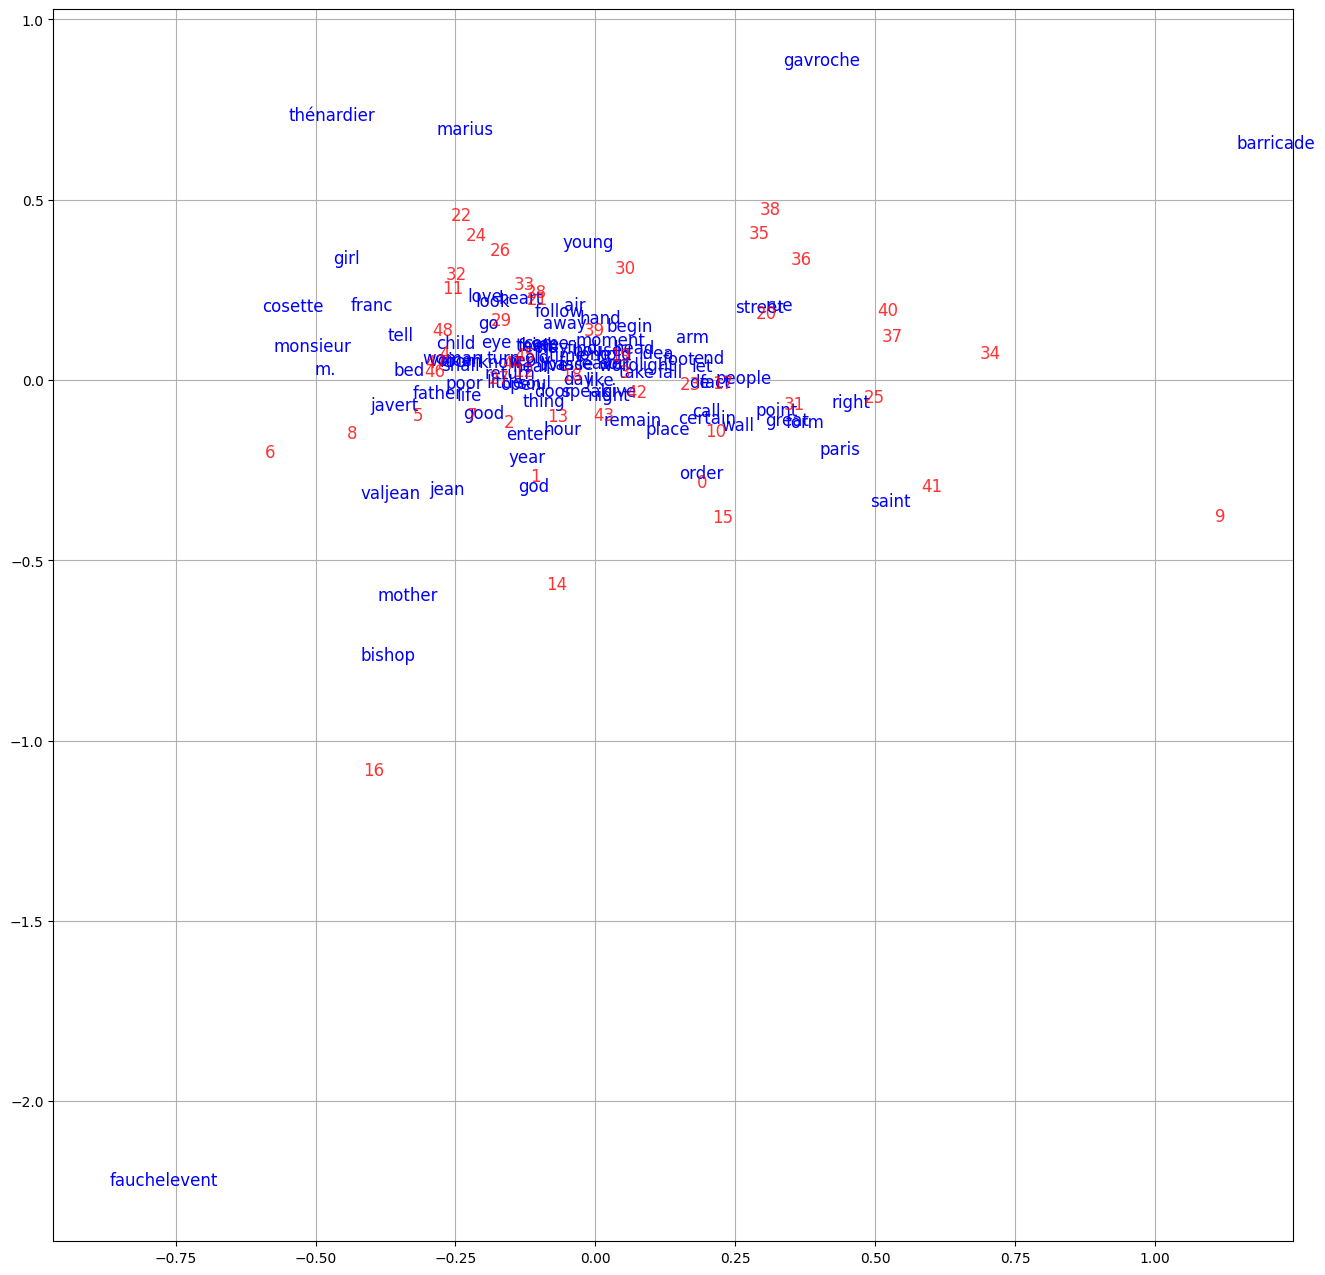

In [52]:
axes = [0, 1]

# Taille du graphique
plt.rcParams["figure.figsize"] = [16, 16]

# Filtre sur les mots les plus fréquents
top_n = 100
word_freqs = get_word_freqs(corpus, dictionary)
top_words = [word for word, _ in word_freqs[:top_n]]
top_word_ids = [dictionary.token2id[word] for word in top_words]
top_row_coord = row_coord[top_word_ids, :]

# On fait une matrice de toutes les coordonées
all_coord = np.concatenate([top_row_coord, col_coord])

# --- Plot

fig, ax = plt.subplots()

ax.scatter(all_coord[:, axes[0]], all_coord[:, axes[1]], alpha=0, color="white")

for i, txt in enumerate(top_words):
    ax.annotate(txt, (top_row_coord[i, axes[0]], top_row_coord[i, axes[1]]),
                size=12, color="blue")

for i, txt in enumerate(range(len(corpus))):
    ax.annotate(txt, (col_coord[i, axes[0]], col_coord[i, axes[1]]),
                size=12, color="red", alpha=0.8)

ax.grid()
plt.show()

---

## 4. L'allocation de Dirichlet latente

Nous allons maintenant faire une allocation de Dirichlet latente avec Gensim. On utilise pour cela la classe `gensim.models.LdaModel`, qui utilise notre corpus en bag-of-words, un nombre de thèmes fixé et notre dictionnaire. L'instance de la classe résultante va contenir tous les résultats pertinents de la méthode.

In [53]:
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

On peut obtenir les principaux mots utilisés dans chaque thème avec la méthode `show_topics()`.

In [54]:
lda_model.show_topics()

[(0,
  '0.026*"jean" + 0.024*"fauchelevent" + 0.023*"valjean" + 0.012*"cosette" + 0.011*"madeleine" + 0.011*"father" + 0.010*"m." + 0.009*"good" + 0.009*"know" + 0.008*"come"'),
 (1,
  '0.028*"jean" + 0.026*"valjean" + 0.008*"take" + 0.007*"like" + 0.007*"long" + 0.006*"day" + 0.006*"javert" + 0.006*"old" + 0.006*"come" + 0.006*"hand"'),
 (2,
  '0.009*"rue" + 0.009*"barricade" + 0.008*"gavroche" + 0.007*"enjolras" + 0.007*"like" + 0.006*"street" + 0.006*"de" + 0.006*"come" + 0.006*"paris" + 0.006*"take"'),
 (3,
  '0.014*"m." + 0.010*"little" + 0.009*"good" + 0.008*"woman" + 0.008*"bishop" + 0.008*"old" + 0.007*"know" + 0.007*"day" + 0.007*"child" + 0.007*"like"'),
 (4,
  '0.026*"marius" + 0.016*"cosette" + 0.011*"thénardier" + 0.009*"come" + 0.008*"know" + 0.008*"go" + 0.008*"day" + 0.008*"old" + 0.007*"time" + 0.007*"father"')]

Laa répartition des thèmes dans un document particulier s'obtient avec `get_document_topics()`.

In [55]:
lda_model.get_document_topics(corpus[1], minimum_probability=0)

[(0, np.float32(3.856128e-05)),
 (1, np.float32(0.004535061)),
 (2, np.float32(0.0013868642)),
 (3, np.float32(0.9938374)),
 (4, np.float32(0.00020212517))]

Les mesures de cohérence sont obtenues avec un objet de classe `gensim.models.CoherenceModel`, qui utilise par défault la mesure $C_v$ (pour plus de détails concernant ces mesures, voir http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf).

In [56]:
coherence_model = CoherenceModel(lda_model, texts=texts, dictionary=dictionary)
coherence_model.get_coherence()

np.float64(0.3349543563436549)

On pourrait effectuer une recherche des meilleurs hyperparmètres $k$, $\alpha$, et
$\eta$ pour notre corpus en maximisant cette mesure de cohérence. Seulement, comme l'optimisation de tous les hyperparamètres peut s'avérer très lente, nous n'allons optimiser ici que le nombre de thèmes. On va créer 3 modèles pour chaque valeur de $k$, afin de limiter l'effet de l'initialisation aléatoire.

In [57]:
ks = list(range(4, 21))
n_tests = 3
coherences = []
for k in tqdm(ks):
  sum_coherence = 0
  for _ in range(n_tests):
    lda_model = LdaModel(corpus, id2word=dictionary,
                        num_topics=k, passes=10)
    sum_coherence += CoherenceModel(lda_model, texts=texts,
                                    dictionary=dictionary).get_coherence()

  coherences.append(sum_coherence / n_tests)

100%|██████████| 17/17 [08:17<00:00, 29.28s/it]


Cette boucle nous permet de tracer la courbe de la cohérence en fonction du nombre de thèmes.

[]

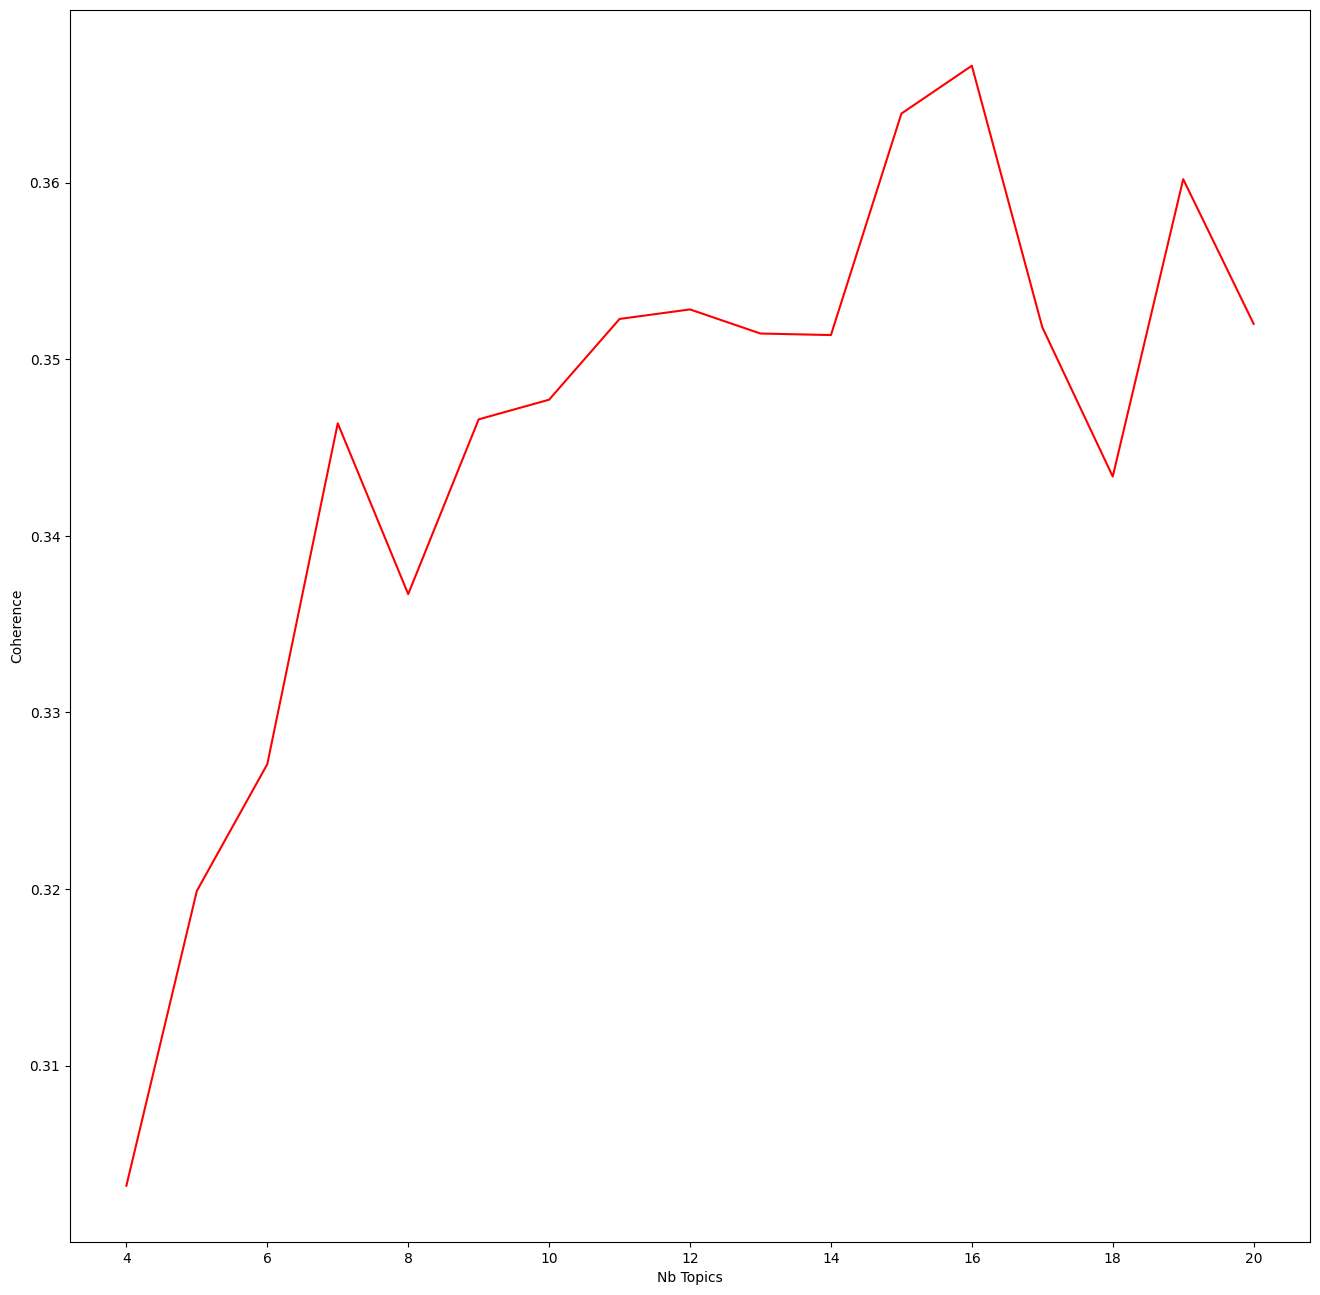

In [58]:
fig, ax = plt.subplots()
ax.plot(ks, coherences, c="red")
ax.set_xlabel("Nb Topics")
ax.set_ylabel("Coherence")
plt.plot()

On va retenir le nombre de thèmes qui maximise la cohérence, et on entraine un modèle avec cet hyperparamètre.

In [59]:
optimal_k = ks[np.argmax(coherences)]
lda_model = LdaModel(corpus, num_topics=optimal_k, id2word=dictionary,
                     passes=10)

Dans des graphiques en barres, nous allons afficher la répartition des 10 mots les plus utilisés par thème. Cela nous permettra de les interpréter.

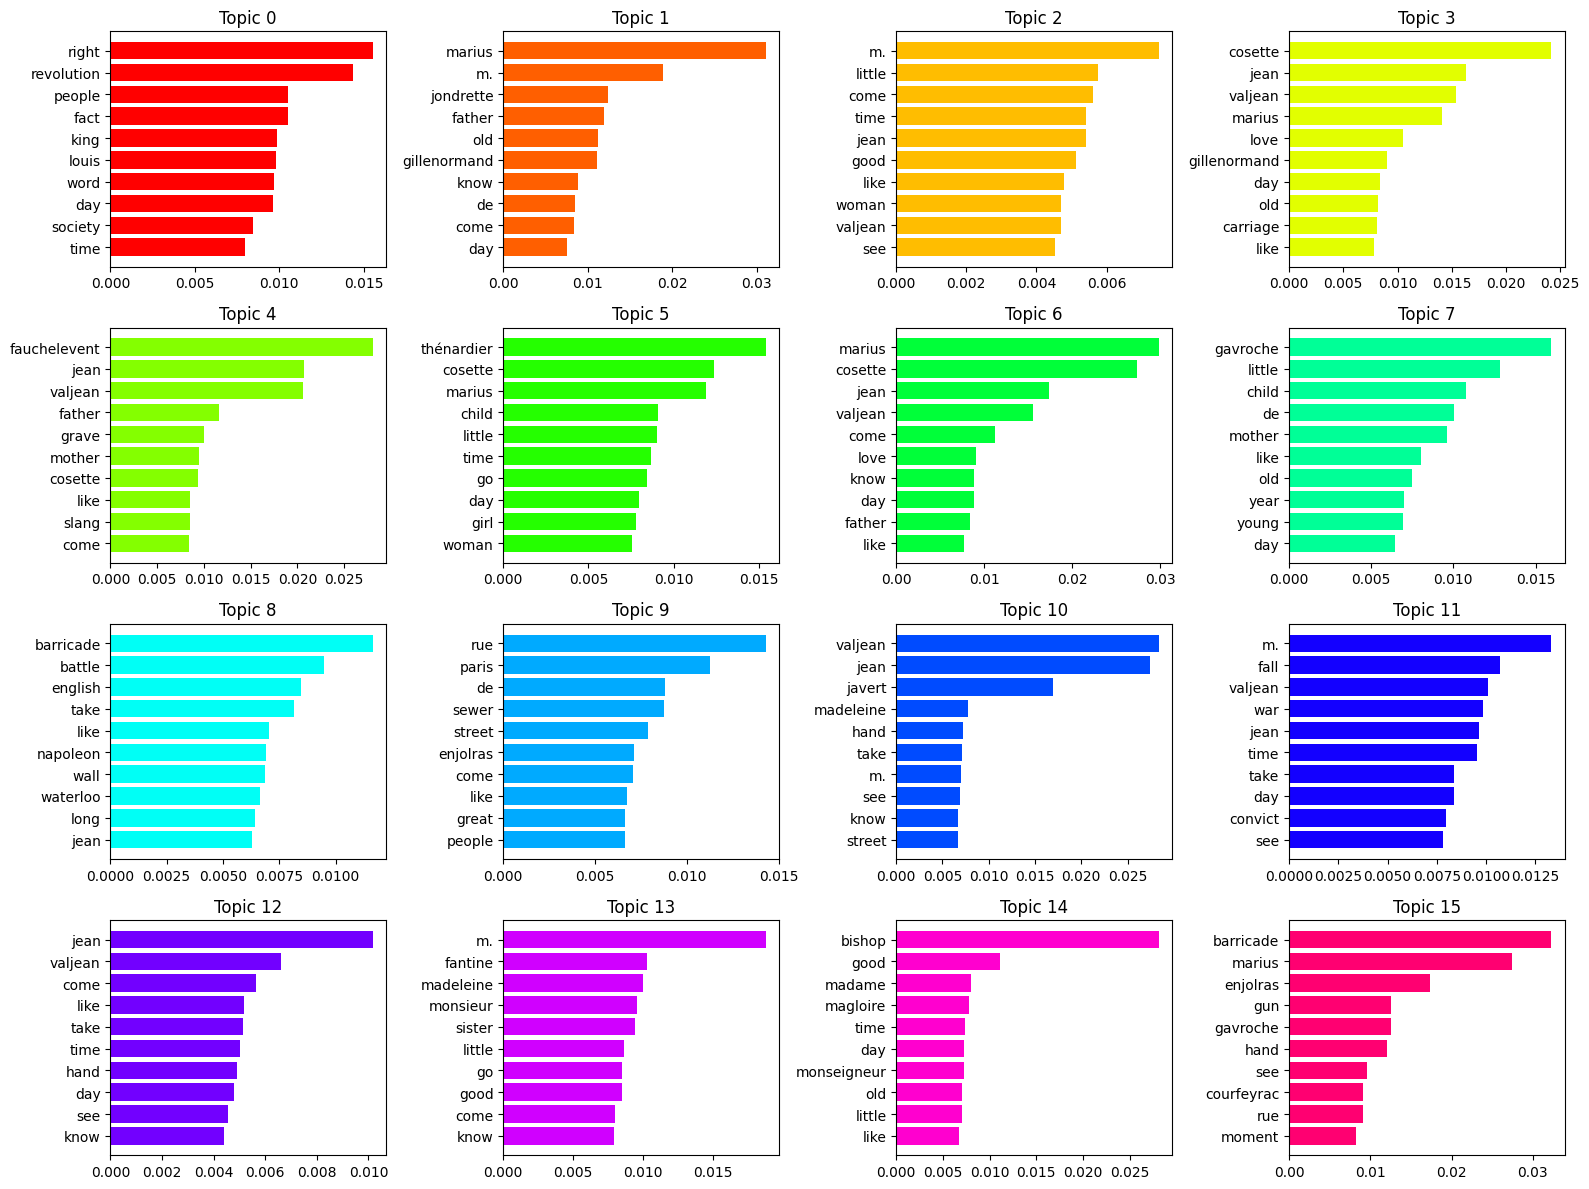

In [60]:
# Pour les couleurs des topics
topic_color = colormaps["hsv"](np.linspace(0.0, 1.0, lda_model.num_topics + 1))

# Pour avoir le nombre d'éléments sur les lignes et colonnes
nx_grid = int(np.sqrt(lda_model.num_topics))
ny_grid= int(np.ceil(lda_model.num_topics / nx_grid))

# On reformate la taille de la figure et on fait une grille
plt.rcParams["figure.figsize"] = [ny_grid*4, nx_grid*3]
fig = plt.figure()
gride_layout = GridSpec(nx_grid, ny_grid)

# Boucle sur les topics
for i in range(lda_model.num_topics):

  # Les 10 mots le plus fréquents dans le topic
  top_words = lda_model.show_topic(i, topn=10)
  words = [word for word, _ in top_words]
  freqs = [freq for _, freq in top_words]

  # On ajoute la figure
  ax = fig.add_subplot(gride_layout[i])
  ax.barh(words, freqs, color=topic_color[i])
  ax.set_title(f"Topic {i}")
  ax.invert_yaxis()

gride_layout.tight_layout(fig)

On fait de même pour la répartition des thèmes dans les documents. En combinant l'interprétation de la sortie précédante avec celle-ci, on peut fréquemment avoir quelques observations pertinentes sur notre corpus.

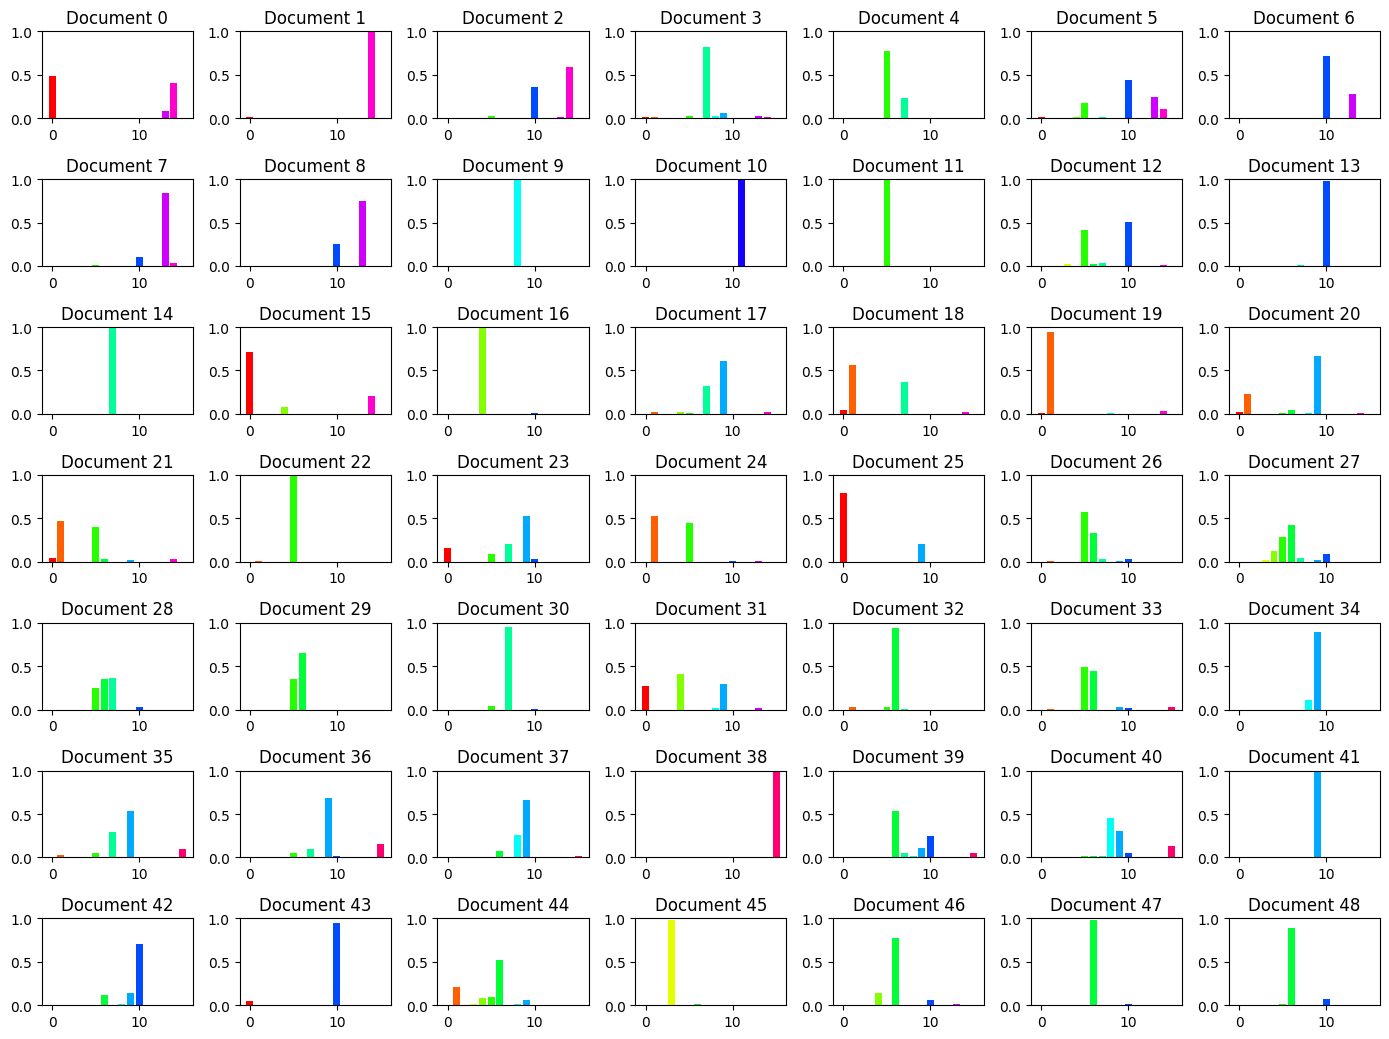

In [61]:
# Pour avoir le nombre d'éléments sur les lignes et colonnes
nx_grid = int(np.sqrt(len(corpus)))
ny_grid= int(np.ceil(len(corpus) / nx_grid))

# On reformate la taille de la figure et on fait une grille
plt.rcParams["figure.figsize"] = [ny_grid*2, nx_grid*1.5]
fig = plt.figure()
gride_layout = GridSpec(nx_grid, ny_grid)

# Boucle sur les topics
for i, document in enumerate(corpus):

  # Les topics dans le document
  topics_freqs = lda_model.get_document_topics(document, minimum_probability=0)
  topics = [topic for topic, _ in topics_freqs]
  freqs = [freq for _, freq in topics_freqs]

  # On ajoute la figure
  ax = fig.add_subplot(gride_layout[i])
  ax.bar(topics, freqs, color=topic_color)
  ax.set_title(f"Document {i}")
  ax.set_ylim([0, 1])

gride_layout.tight_layout(fig)

---

## 5. Word2Vec

Finalement, nous allons utiliser Gensim pour entrainer un modèle de type **Word2Vec** sur notre corpus. Cela nous permettra de visuliser une carte sémantique et syntaxique basée sur Les Misérables.

Gensim contient beaucoup de méthodes de word embedding, ainsi que des outils pour charger des word embeddings venant de sources externes (e.g. de https://wikipedia2vec.github.io/wikipedia2vec/ ou de https://fasttext.cc/docs/en/crawl-vectors.html).

On commence par charger à nouveau notre corpus, mais en ne gardant uniquement que la séparation en tokens et en phrases. Le résultat de cette opération est une liste de phrases qui sont des listes de tokens.

In [62]:
corpus_pp_path = "/content/drive/MyDrive/Colab Notebooks/ml_data/TP10/by_book_pp"
file_names = os.listdir(corpus_pp_path)

sentences = []
for file_name in file_names:
  with open(f"{corpus_pp_path}/{file_name}") as text_file:
    text_sentences = text_file.readlines()
    text_token_sentences = [text_sentence.split() for
                            text_sentence in text_sentences]
    sentences.extend(text_token_sentences)

sentences[0]

['les', 'misérables', 'preface']

On utilise la classe `gensim.models.Word2Vec` pour créer notre embedding avec les mots de fréquence minimale 100 (`min_count=100`), une fenêtre de +/-5 tokens (`window=5`), une dimension d'embedding de 300 (`vector_size=300`) et avec la méthode skip-gram (`sg=1`). L'objet de retour (ici `wv_model`) contient de nombreuses informations sur le résultat.

In [63]:
wv_model = Word2Vec(sentences, min_count=100, window=5, vector_size=300, sg=1)

On peut voir le vocabulaire qui a été transformé en vecteur avec l'attribut `wv.vocab`.

In [64]:
wv_vocab = wv_model.wv.key_to_index
wv_words = list(wv_vocab.keys())
len(wv_words)

441

Vérifions au préalable si certains mots sont bien dans notre embedding.

In [65]:
print("gavroche" in wv_words)
print("cosette" in  wv_words)
print("valjean" in  wv_words)

True
True
True


Le vecteur d'un mot particulier est donné avec la méthode `wv_model.wv.get_vector()`. On affiche les 10 premières coordonnées de "cosette".

In [66]:
wv_model.wv.get_vector("cosette")[0:10]

array([ 0.05388348,  0.13285135,  0.02303923,  0.09333002, -0.17121944,
       -0.11159007,  0.01827363,  0.19811545,  0.02285229,  0.00781742],
      dtype=float32)

On peut obtenir la similarité du cosinus (https://en.wikipedia.org/wiki/Cosine_similarity) entre des couples mots. Avec les word embeddings, on utilise quasiment exclusivement cette similarité pour mesurer la proximité entre les vecteurs.

In [67]:
print(wv_model.wv.similarity("valjean", "cosette"))
print(wv_model.wv.similarity("valjean", "gavroche"))
print(wv_model.wv.similarity("cosette", "gavroche"))

0.7357849
0.5357821
0.7114197


Il est également possible d'avoir les mots les plus similaires à un mot donné.

In [68]:
wv_model.wv.most_similar("cosette")

[('marius', 0.9010487794876099),
 ('pause', 0.8781106472015381),
 ('fantine', 0.8774930238723755),
 ('continue', 0.8492462635040283),
 ('listen', 0.8447422385215759),
 ('soon', 0.841275155544281),
 ('thou', 0.8387840986251831),
 ('think', 0.8310457468032837),
 ('exclaim', 0.8307632803916931),
 ('forget', 0.8289012312889099)]

In [69]:
wv_model.wv.most_similar("valjean")

[('convict', 0.8336817622184753),
 ('recognize', 0.8170298933982849),
 ('cosette', 0.7357848882675171),
 ('remain', 0.7288203835487366),
 ('moment', 0.7040982842445374),
 ('javert', 0.6979842185974121),
 ('pause', 0.6869488954544067),
 ('seek', 0.6815629601478577),
 ('silence', 0.6744802594184875),
 ('prisoner', 0.6727491617202759)]

Des "calculs" sont possibles dans la méthode `wv_model.wv.most_similar()`.

In [70]:
wv_model.wv.most_similar(positive=["monsieur", "cosette"], negative=["valjean"])

[('sister', 0.875137984752655),
 ('daughter', 0.8691832423210144),
 ('yes', 0.8655902743339539),
 ('address', 0.8439401388168335),
 ('gentleman', 0.8371121883392334),
 ('reply', 0.8236821293830872),
 ('brother', 0.8223061561584473),
 ('want', 0.8195735216140747),
 ('sir', 0.8143653273582458),
 ('resume', 0.8104207515716553)]

On va maintenant afficher les mots les plus fréquents de notre embedding. Commençons par extraire les 100 premiers mots du corpus.

In [71]:
n_top_words = 100
word_freq = [(word, wv_model.wv.get_vecattr(wv_vocab[word], 'count')) for
             word in wv_words]
word_freq = sorted(word_freq, key=lambda item: item[1], reverse=True)
top_words = word_freq[:n_top_words]
top_words[:10]

[('man', np.int64(2569)),
 ('marius', np.int64(1340)),
 ('jean', np.int64(1218)),
 ('valjean', np.int64(1105)),
 ('come', np.int64(1026)),
 ('like', np.int64(1008)),
 ('cosette', np.int64(1005)),
 ('know', np.int64(968)),
 ('little', np.int64(964)),
 ('day', np.int64(961))]

On extrait leurs coordonnées avec `wv_model.wv.get_vector()`.

In [72]:
top_vectors = np.empty((len(top_words), 300), dtype="f")
for i, (word, _) in enumerate(top_words):
  top_vectors[i] = wv_model.wv.get_vector(word)
top_vectors.shape

(100, 300)

On effectue une projection tSNE de ces vecteurs dans un espace à 2 dimensions.

In [73]:
coords_2d = TSNE(n_components=2, perplexity=5,
                 init="pca",
                 learning_rate="auto").fit_transform(top_vectors)

Et on affiche les vecteurs. La structure entre les différents mots permet d'obtenir de l'information sur l'utilisation ce ces mots dans le corpus.

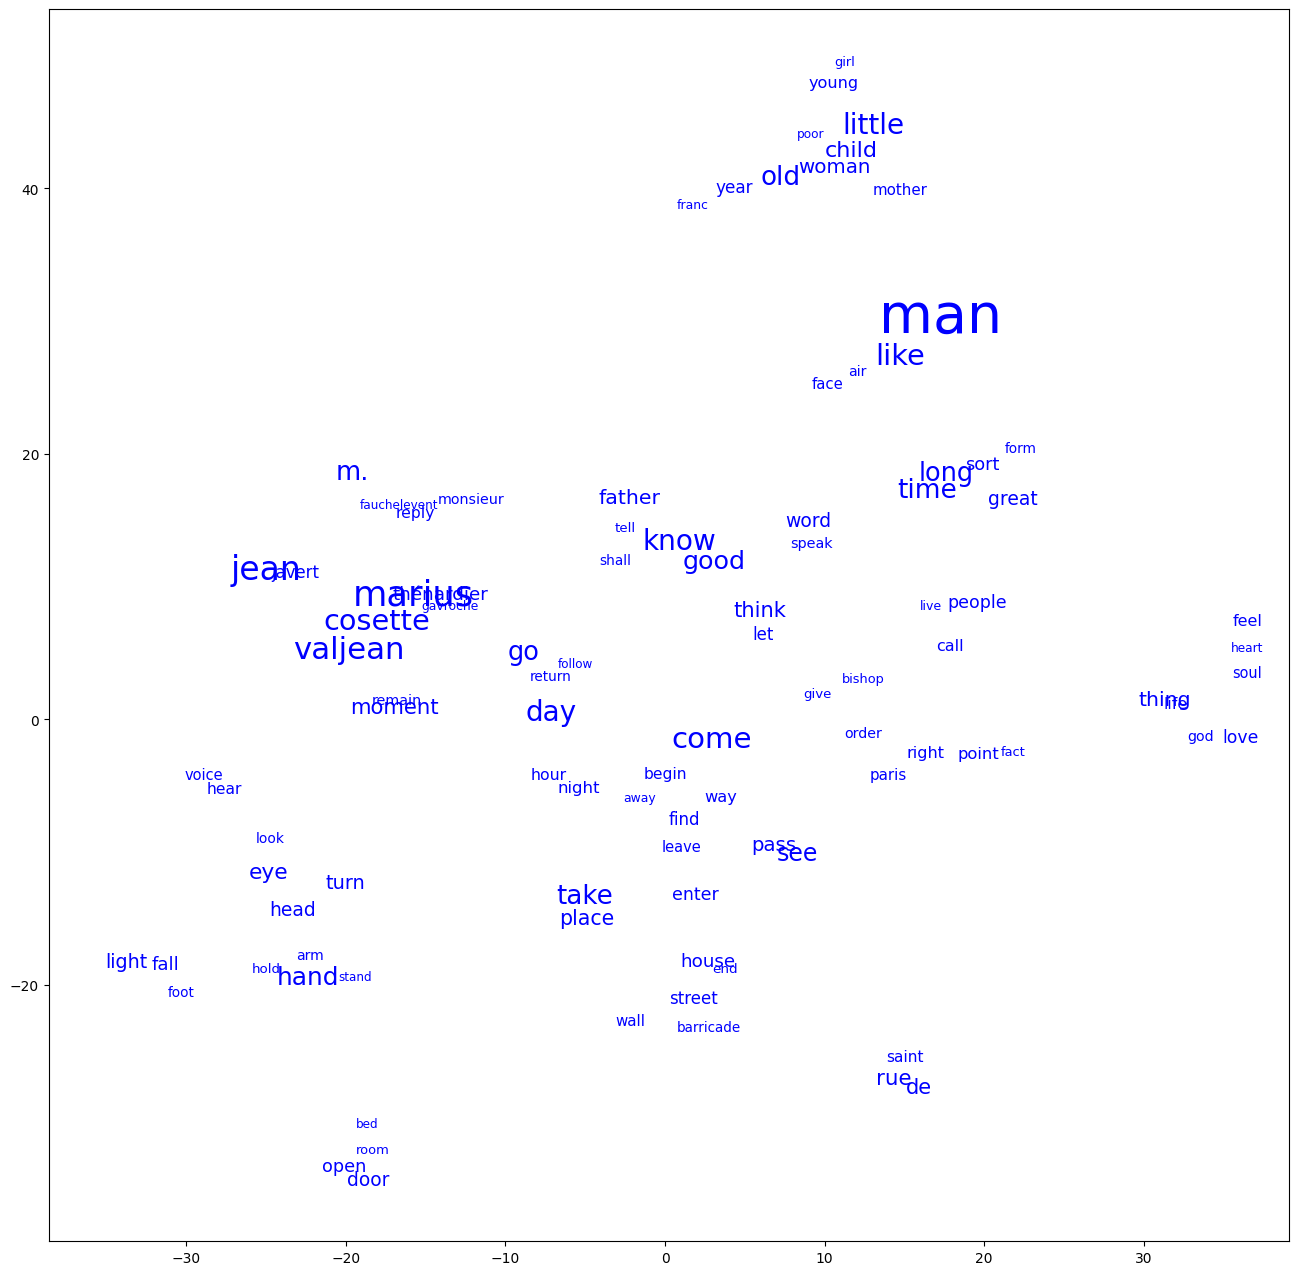

In [74]:
plt.rcParams["figure.figsize"] = [16, 16]
plt.scatter(coords_2d[:,0], coords_2d[:,1], alpha=0)
for word, x, y in zip(top_words, coords_2d[:,0], coords_2d[:,1]):
    plt.annotate(word[0], xy=(x, y), xytext=(0, 0), textcoords="offset points",
                 size=(word[1]/top_words[0][1])**(0.7)*40,
                 color="blue")
plt.show()

---